In [1]:
import h5py 
import scipy 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import tkinter 
import scipy.interpolate 
from sklearn.neighbors import KernelDensity 
from scipy.stats import gaussian_kde 

In [9]:
def init_params(xt): 
    n_feat = xt.shape[0] 
    w = np.zeros((1, n_feat)) 
    b = np.zeros(1) 

    return w, b 

def gradient_descent(xtrain, ytrain, learning_rate, maxit): 

    w, b = init_params(xtrain)  
    wp = 0 
    bp = 0 
    zi = np.zeros(shape = (xtrain.shape[0], 1)) 
    J = [] 
    it = 0 
    n = ytrain.shape[0] 
    nw = 1 
    nb = 1 

    while (nw > 0 or nb > 0) and it != maxit:
        wp = w 
        bp = b 
        zi = np.sum(w * xtrain , axis = 1, keepdims = True) + b 
        dJdb = (2/n) * np.sum(zi - ytrain, axis = 0, keepdims = True) 
        dJdw = (2/n) * np.sum((zi - ytrain) * xtrain, axis = 0, keepdims = True) 

        w = w - learning_rate * dJdw 
        b = b - learning_rate * dJdb 
        
        nw = np.sqrt(np.linalg.norm(w - wp)) 
        nb = np.sqrt(np.linalg.norm(b - bp)) 

        it += 1 
        J.append((1/n) * np.sum((ytrain -  zi) ** 2)) 

    return J, it, w, b , zi 

In [74]:
hits = 0 
frames = 0 
hit_intensity = 0 
hit_intensities = np.empty(shape = (0)) 
hit_x = np.empty(shape = (0)) 

hit_y = np.empty(shape = (0)) 
plotFull = False

# File name(s)
f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d626_analysis/spts.cxi' # d626 - 15 nm GroEL 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d625_analysis/spts.cxi' # d625 - 15 nm GroEL
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d624_analysis/spts.cxi' # d624 - 20 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d621_c_analysis/spts.cxi' # d621 - 20 nm
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d619_analysis/spts.cxi' # d619 - 30 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/data00617_analysis/spts.cxi' # d617 - 40 nm 
#f_name = '/scratch/fhgfs/filipe/SPTS/shared_data_2021/d614_analysis/spts.cxi' # d614 - 50 nm 

f = h5py.File(f_name, 'r') 
frames += f['/5_detect/n'].shape[0] 
print('Number of frames:', frames) 

for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
    for j in range(0, f['/5_detect/n'][i]): # particle counter 
        if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
            hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
            hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 

hits += np.sum(f['/5_detect/n']) 
print('Number of raw hits:', hits) 
a = np.array(f['/6_analyse/peak_sum']) 

real_hits = np.sum((a > 0)) 
print('Number of real hits (intensity > 0):', real_hits) 
 
hit_intensities = np.append(hit_intensities, a[a > 0]) 

Number of frames: 3200
Number of raw hits: 2279
Number of real hits (intensity > 0): 1667


In [75]:
av_intensity = np.mean(hit_intensities) 
med_intensity = np.median(hit_intensities) 
std_intensity = np.std(hit_intensities) 
min_intensity = np.min(hit_intensities) 
max_intensity = np.max(hit_intensities) 
mad_intensity = scipy.stats.median_abs_deviation(hit_intensities)
print("------------------------------------------------------")
print("Intensity statistics before outlier removal:")
print("------------------------------------------------------")
print("%s hits before removal." % (real_hits))
print('Average intensity:', av_intensity) 
print('Median intensity:', med_intensity) 
print("MAD intensity: %s." % (mad_intensity))
print('Standard deviation intensity:', std_intensity) 
print('Minimum intensity:', min_intensity) 
print('Maximum intensity:', max_intensity) 
if plotFull:
    with np.printoptions(threshold = np.inf):
        print(np.sort(hit_intensities))
else:
    print(np.sort(hit_intensities))
print("------------------------------------------------------")
print() 

#### TO - DO 

### Removing outlier(s) from particle intensities and then calculating sixth-root intensities 
# Using IQR
percentile_25 = np.percentile(hit_intensities, q = 25)
percentile_75 = np.percentile(hit_intensities, q = 75)
q1, q3 = percentile_25, percentile_75
iqr = q3 - q1 

iqr_fac = 1.5 
iqr_low = q1 - iqr_fac * iqr 
iqr_high = q3 + iqr_fac * iqr
# Using MAD 
mad_fac = 4 
mad_low = med_intensity - mad_fac * mad_intensity 
mad_high = med_intensity + mad_fac * mad_intensity 

hits_corrected, hitx, hity = [], [], []
hits_remain, hits_del = 0, 0
for h in range(len(hit_intensities)): 
    hit_h = hit_intensities[h] 
    hx, hy = hit_x[h], hit_y[h] 
    if hit_h >= iqr_low and hit_h <= iqr_high: 
        hitx.append(hx) 
        hity.append(hy) 
        hits_corrected.append(hit_h) 
        hits_remain += 1
    else:
        hits_del += 1

hits_corrected = np.array(hits_corrected)
hitx = np.array(hitx) 
hity = np.array(hity) 

print("------------------------------------------------------")
print("Intensity statistics after outlier removal:")
print("------------------------------------------------------")
print("%s hits after removal." % (hits_remain))
print("%s hits removed." % (hits_del)) 
print('average intensity:', np.mean(hits_corrected)) 
print('median intensity:', np.median(hits_corrected)) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hits_corrected)))
print('standard deviation intensity:', np.std(hits_corrected)) 
print('minimum intensity:', np.min(hits_corrected)) 
print('maximum intensity:', np.max(hits_corrected)) 
if plotFull:
    with np.printoptions(threshold = np.inf):
        print(np.sort(hits_corrected))
else:
    print(np.sort(hits_corrected)) 
print("------------------------------------------------------")
print() 

------------------------------------------------------
Intensity statistics before outlier removal:
------------------------------------------------------
1667 hits before removal.
Average intensity: 609.1553689262148
Median intensity: 195.0
MAD intensity: 89.0.
Standard deviation intensity: 11712.665180313594
Minimum intensity: 1.0
Maximum intensity: 476976.0
[1.00000e+00 1.00000e+00 2.00000e+00 ... 1.55170e+04 1.55970e+04
 4.76976e+05]
------------------------------------------------------

------------------------------------------------------
Intensity statistics after outlier removal:
------------------------------------------------------
1597 hits after removal.
70 hits removed.
average intensity: 198.71509079524108
median intensity: 188.0
MAD intensity: 83.0.
standard deviation intensity: 117.13872066365371
minimum intensity: 1.0
maximum intensity: 551.0
[  1.   1.   2. ... 541. 547. 551.]
------------------------------------------------------



In [76]:
print("------------------------------------------------------")
print("Sixth root intensity statistics before outlier removal:")
print("------------------------------------------------------")
print('average intensity:', np.mean(hit_intensities ** (1/6))) 
print('median intensity:', np.median(hit_intensities ** (1/6))) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hit_intensities ** (1/6))))
print('standard deviation intensity:', np.std(hit_intensities ** (1/6))) 
print('minimum intensity:', np.min(hit_intensities ** (1/6))) 
print('maximum intensity:', np.max(hit_intensities ** (1/6))) 

if plotFull: 
    with np.printoptions(threshold = np.inf):
        print(np.sort(hit_intensities ** (1/6)))
else:
    print(np.sort(hit_intensities ** (1/6))) 
print("------------------------------------------------------")
print() 

hits_sixth_root = hits_corrected ** (1/6) 
print("------------------------------------------------------")
print("Sixth root intensity statistics after outlier removal:")
print("------------------------------------------------------")
print('average intensity:', np.mean(hits_sixth_root)) 
print('median intensity:', np.median(hits_sixth_root)) 
print("MAD intensity: %s." % (scipy.stats.median_abs_deviation(hits_sixth_root)))
print('standard deviation intensity:', np.std(hits_sixth_root)) 
print('minimum intensity:', np.min(hits_sixth_root)) 
print('maximum intensity:', np.max(hits_sixth_root)) 

if plotFull: 
    with np.printoptions(threshold = np.inf):
        print(np.sort(hits_sixth_root))
else:
    print(np.sort(hits_sixth_root))
print("------------------------------------------------------")
print() 

------------------------------------------------------
Sixth root intensity statistics before outlier removal:
------------------------------------------------------
average intensity: 2.389589024593956
median intensity: 2.4080884530367643
MAD intensity: 0.1863894322544728.
standard deviation intensity: 0.4359896772350157
minimum intensity: 1.0
maximum intensity: 8.83926365018621
[1.         1.         1.12246205 ... 4.99422334 4.99850555 8.83926365]
------------------------------------------------------

------------------------------------------------------
Sixth root intensity statistics after outlier removal:
------------------------------------------------------
average intensity: 2.3350892460854724
median intensity: 2.393460740430567
MAD intensity: 0.17930157817296655.
standard deviation intensity: 0.3064940794994455
minimum intensity: 1.0
maximum intensity: 2.8632455855298695
[1.         1.         1.12246205 ... 2.8545186  2.85977076 2.86324559]
--------------------------------

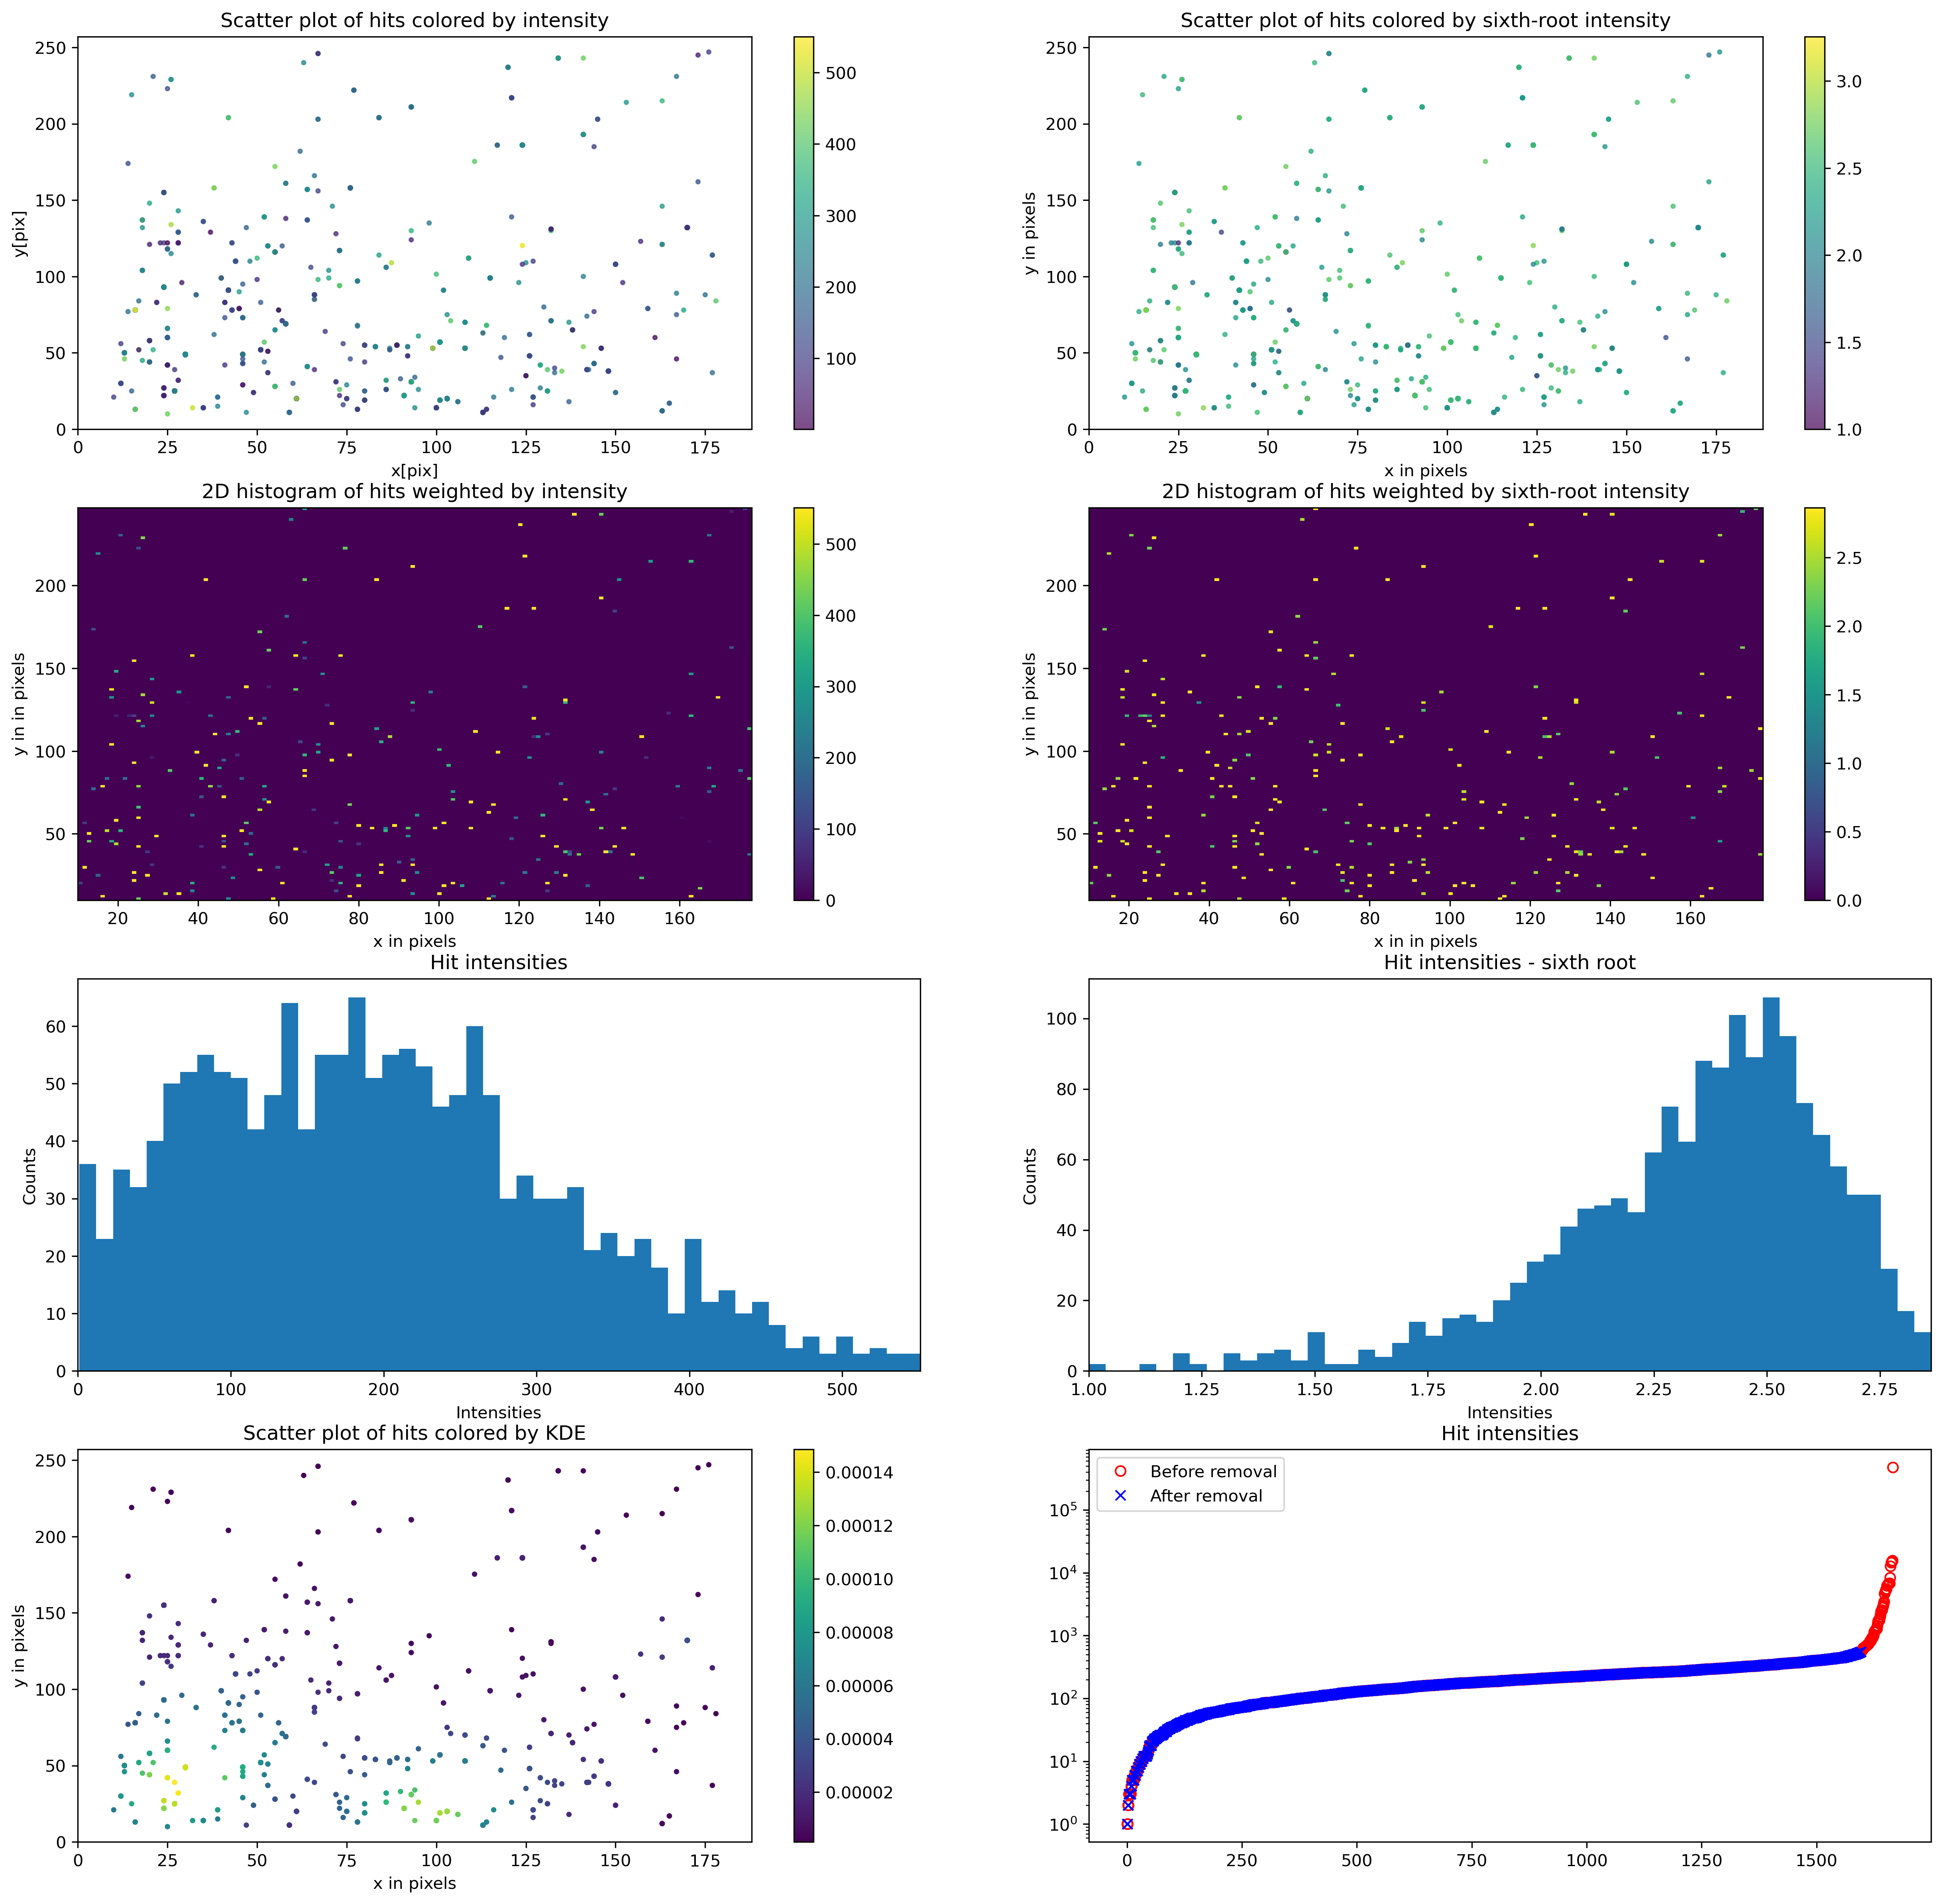

In [77]:
fig, ax = plt.subplots(4 , 2, figsize = (20, 20), dpi = 300) 

xmin = hitx.min() 
xmax = hitx.max() 
ymin = hity.min() 
ymax = hity.max() 
xy = np.vstack([hitx,hity]) 

z_kde = gaussian_kde(xy) 
max_kde = z_kde(xy).max() 

xgrid, ygrid = np.mgrid[xmin:xmax:500j, ymin:ymax:500j] 
xyg = np.vstack([xgrid.ravel(), ygrid.ravel()]) 
z_kde_grid = np.reshape(z_kde(xyg).T, xgrid.shape) 

c = 'viridis' 
num_bins = 50

xpmin = xmin - 10 
ypmin = ymin - 10 

xpmax = xmax + 10 
ypmax = ymax + 10 

s1 = ax[0,0].scatter(hitx , hity , c = hits_corrected, s = 5, 
                     cmap = c, alpha = 0.7, vmin = np.min(hits_corrected), vmax = np.mean(hits_corrected) + 3 * np.std(hits_corrected)) 
ax[0,0].set_ylim(ypmin, ypmax) 
ax[0,0].set_xlim(xpmin, xpmax)
ax[0,0].set_xlabel('x[pix]') 
ax[0,0].set_ylabel('y[pix]') 
ax[0,0].set_title('Scatter plot of hits colored by intensity') 
fig.colorbar(s1, ax = ax[0,0]) 

s2 = ax[0,1].scatter(hitx , hity , c = hits_sixth_root, s = 5, cmap = c, alpha = 0.7 , 
                     vmin = np.min(hits_sixth_root), vmax = np.mean(hits_sixth_root) + 3 * np.std(hits_sixth_root)) 
ax[0,1].set_ylim(ypmin, ypmax) 
ax[0,1].set_xlim(xpmin, xpmax)
ax[0,1].set_xlabel('x in pixels') 
ax[0,1].set_ylabel('y in pixels') 
ax[0,1].set_title('Scatter plot of hits colored by sixth-root intensity') 
fig.colorbar(s2, ax = ax[0,1]) 

s3 = ax[1,0].hist2d(hitx, hity, bins = 150, weights = hits_corrected, vmin = 0, vmax = np.max(hits_corrected)) 
ax[1,0].set_xlabel('x in pixels') 
ax[1,0].set_ylabel('y in in pixels') 
ax[1,0].set_title('2D histogram of hits weighted by intensity') 
fig.colorbar(s3[3], ax = ax[1,0]) 

s4 = ax[1,1].hist2d(hitx, hity, bins = 150, weights = hits_sixth_root, vmin = 0, vmax = np.max(hits_sixth_root)) 
ax[1,1].set_xlabel('x in in pixels') 
ax[1,1].set_ylabel('y in in pixels') 
ax[1,1].set_title('2D histogram of hits weighted by sixth-root intensity') 
fig.colorbar(s4[3], ax = ax[1,1]) 

ax[2,0].hist(hits_corrected, bins = num_bins) 
ax[2,0].set_title('Hit intensities') 
ax[2,0].set_xlim(np.min(hits_corrected), np.max(hits_corrected)) 
ax[2,0].set_xlabel('Intensities') 
ax[2,0].set_ylabel('Counts') 
ax[2,0].set_xlim(0, np.max(hits_corrected)) 

ax[2,1].hist(hits_sixth_root, bins = num_bins) 
ax[2,1].set_xlim(np.min(hits_sixth_root), np.max(hits_sixth_root)) 
ax[2,1].set_title('Hit intensities - sixth root') 
ax[2,1].set_xlabel('Intensities') 
ax[2,1].set_ylabel('Counts') 

s5 = ax[3,0].scatter(hitx , hity , c = z_kde(xy), s = 5, alpha = 1.0) 
ax[3,0].set_ylim(ypmin, ypmax) 
ax[3,0].set_xlim(xpmin, xpmax)
ax[3,0].set_xlabel('x in pixels') 
ax[3,0].set_ylabel('y in pixels') 
ax[3,0].set_title('Scatter plot of hits colored by KDE') 
fig.colorbar(s5, ax = ax[3,0]) 

ax[3,1].plot(np.sort(hit_intensities), 'ro', markerfacecolor = "None", markeredgecolor = "red") 
ax[3,1].set_title("Hit intensities") 
ax[3,1].set_yscale("log") 
ax[3,1].plot(np.sort(hits_corrected), 'bx', markerfacecolor = "None", markeredgecolor = "blue") 
ax[3,1].legend(["Before removal", "After removal"]); 

num = 20 
save_name = 'hit_density_' + str(num) + '.pdf' 
plt.savefig(save_name) 

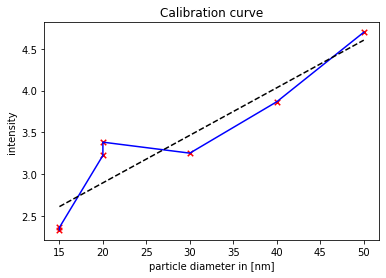

In [39]:
### Constructing calibration curve and performing linear fit 
diams = np.array([15, 15, 20, 20, 30, 40, 50]) 
intens = np.array([2.3350892460854724, 2.3645170265332958, 3.2252841338754332 , 3.383917731093221, 3.2527086137541024, 3.867076605359937, 4.697551324228289]) 

# Linear regression on the particle diameter and sixth root intensity data 
a_parts, b_parts, r_parts, p_v, std_err = scipy.stats.linregress(diams, intens)

fig, ax = plt.subplots() 
ax.plot(diams, intens, 'b') 
ax.plot(diams, (a_parts * diams + b_parts), '--k') 
ax.scatter(diams, intens, s = 30, c = 'r', marker = 'x') 
ax.set_title("Calibration curve") 
ax.set_xlabel("particle diameter in nm") 
ax.set_ylabel("sixth root intensity"); 

In [36]:
print("------------------------------------------------------")
print("Linear regression summary:")
print("------------------------------------------------------")
print('slope:', a_parts) 
print('intercept:', b_parts) 
print("correlation coefficient or r-value: %s" % (r_parts))
print('p-value:', p_v) 
print('standard error:', std_err)  
print("------------------------------------------------------")
print() 

------------------------------------------------------
Linear regression statistics:
------------------------------------------------------
slope: 0.05683302643306857
intercept: 1.7611242369495321
correlation coefficient or r-value: 0.9283676346327081
p-value: 0.0025371978011629807
standard error: 0.010175256195720342
------------------------------------------------------



In [ ]:
# Closing the file 
f.close() 